In [1]:
# imports

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
from anthropic import Anthropic

In [2]:
import os
from huggingface_hub import login

os.environ["PATH"] += r";C:\Program Files\Git\cmd"
hf_token = "*"
login(hf_token, add_to_git_credential=True)

In [3]:

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
# os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
# os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [4]:
# moved our Tester into a separate package
# call it with Tester.test(function_name, test_dataset)

from items import Item
from testing import Tester

In [5]:
openai = OpenAI()

In [6]:
%matplotlib inline

In [8]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('train_lite.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test_lite.pkl', 'rb') as file:
    test = pickle.load(file)

In [9]:
# OpenAI recommends fine-tuning with populations of 50-100 examples
# But as our examples are very small, I'm suggesting we go with 200 examples (and 1 epoch)

fine_tune_train = train[:200]
fine_tune_validation = train[200:250]

In [10]:
# First let's work on a good prompt for a Frontier model
# Notice that I'm removing the " to the nearest dollar"
# When we train our own models, we'll need to make the problem as easy as possible,
# but a Frontier model needs no such simplification.

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": f"Price is ${item.price:.2f}"}
    ]

In [11]:
messages_for(train[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': 'How much does this cost?\n\nBSHTU 3.5mm (Mini) 1/8 TRS Stereo Female to 2 Dual 1/4 6.35mm Mono TS Male Y Splitter Cable Audio Adapter Stereo Converter Guitar Amp (0.2M)\nItem 3.5mm (Mini) 1/8 TRS Stereo Female to 2 Dual 1/4 6.35mm Mono TS Male Y Splitter Cable Audio Adapter Stereo Converter Guitar Amp This centbest standard 3.5 to 6.35 mono audio cable can be used to combine two TS 1/4 into one 3.5mm TRS Stereo or Split out a 3.5mm TRS Stereo to seperate cables with 1/4 connections for a variety of audio devices.Features Cable'},
 {'role': 'assistant', 'content': 'Price is $6.97'}]

In [12]:
# Convert the items into a list of json objects - a "jsonl" string
# Each row represents a message in the form:
# {"messages" : [{"role": "system", "content": "You estimate prices...


def make_jsonl(items):
    result = ""
    for item in items:
        messages = messages_for(item)
        messages_str = json.dumps(messages)
        result += '{"messages": ' + messages_str +'}\n'
    return result.strip()

In [13]:
print(make_jsonl(train[:3]))

{"messages": [{"role": "system", "content": "You estimate prices of items. Reply only with the price, no explanation"}, {"role": "user", "content": "How much does this cost?\n\nBSHTU 3.5mm (Mini) 1/8 TRS Stereo Female to 2 Dual 1/4 6.35mm Mono TS Male Y Splitter Cable Audio Adapter Stereo Converter Guitar Amp (0.2M)\nItem 3.5mm (Mini) 1/8 TRS Stereo Female to 2 Dual 1/4 6.35mm Mono TS Male Y Splitter Cable Audio Adapter Stereo Converter Guitar Amp This centbest standard 3.5 to 6.35 mono audio cable can be used to combine two TS 1/4 into one 3.5mm TRS Stereo or Split out a 3.5mm TRS Stereo to seperate cables with 1/4 connections for a variety of audio devices.Features Cable"}, {"role": "assistant", "content": "Price is $6.97"}]}
{"messages": [{"role": "system", "content": "You estimate prices of items. Reply only with the price, no explanation"}, {"role": "user", "content": "How much does this cost?\n\nFifine Karaoke Microphone, Dynamic Vocal Microphone for Speaker,Wired Handheld Mic wi

In [14]:
# Convert the items into jsonl and write them to a file

def write_jsonl(items, filename):
    with open(filename, "w") as f:
        jsonl = make_jsonl(items)
        f.write(jsonl)

In [15]:
write_jsonl(fine_tune_train, "fine_tune_train.jsonl")

In [16]:
write_jsonl(fine_tune_validation, "fine_tune_validation.jsonl")

In [17]:
with open("fine_tune_train.jsonl", "rb") as f:
    train_file = openai.files.create(file=f, purpose="fine-tune")

In [18]:
train_file

FileObject(id='file-TgLH9qBmePv74QwwLAEaro', bytes=190057, created_at=1761755603, filename='fine_tune_train.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

In [19]:
with open("fine_tune_validation.jsonl", "rb") as f:
    validation_file = openai.files.create(file=f, purpose="fine-tune")

In [20]:
validation_file

FileObject(id='file-TdnojezuWypb6TC9VNoCyh', bytes=48381, created_at=1761755614, filename='fine_tune_validation.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

In [21]:
wandb_integration = {"type": "wandb", "wandb": {"project": "gpt-pricer"}}

In [22]:
train_file.id

'file-TgLH9qBmePv74QwwLAEaro'

In [23]:
openai.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=validation_file.id,
    model="gpt-4o-mini-2024-07-18",
    seed=42,
    hyperparameters={"n_epochs": 1},
    integrations = [wandb_integration],
    suffix="pricer"
)

FineTuningJob(id='ftjob-UG6lhINPUS1vHBpMtSFoOmIs', created_at=1761757208, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-pTIl3RoKleqyX7UySR2wdKmZ', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-TgLH9qBmePv74QwwLAEaro', validation_file='file-TdnojezuWypb6TC9VNoCyh', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-UG6lhINPUS1vHBpMtSFoOmIs'))], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1))), user_provided_suffix='price

In [24]:
openai.fine_tuning.jobs.list(limit=1)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-UG6lhINPUS1vHBpMtSFoOmIs', created_at=1761757208, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-pTIl3RoKleqyX7UySR2wdKmZ', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-TgLH9qBmePv74QwwLAEaro', validation_file='file-TdnojezuWypb6TC9VNoCyh', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-UG6lhINPUS1vHBpMtSFoOmIs'))], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1))), user_pr

In [25]:
job_id = openai.fine_tuning.jobs.list(limit=1).data[0].id

In [26]:
job_id

'ftjob-UG6lhINPUS1vHBpMtSFoOmIs'

In [27]:
openai.fine_tuning.jobs.retrieve(job_id)

FineTuningJob(id='ftjob-UG6lhINPUS1vHBpMtSFoOmIs', created_at=1761757208, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-pTIl3RoKleqyX7UySR2wdKmZ', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-TgLH9qBmePv74QwwLAEaro', validation_file='file-TdnojezuWypb6TC9VNoCyh', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-UG6lhINPUS1vHBpMtSFoOmIs'))], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1))), user_provided_suffix='pricer', usage_metric

In [30]:
openai.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10).data

[FineTuningJobEvent(id='ftevent-nvj79GJYoEBfTWCaLmstZPiU', created_at=1761758837, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-jzrMdXj0kUO5lTsImZoOi5Qi', created_at=1761758831, level='info', message='Usage policy evaluations completed, model is now enabled for sampling', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-qxwnwhFIPx04Wa0NSRmF73E4', created_at=1761758831, level='info', message='Moderation checks for snapshot ft:gpt-4o-mini-2024-07-18:personal:pricer:CW3yj3CJ passed.', object='fine_tuning.job.event', data={'blocked': False, 'results': [{'flagged': False, 'category': 'harassment/threatening', 'enforcement': 'blocking'}, {'flagged': False, 'category': 'sexual', 'enforcement': 'blocking'}, {'flagged': False, 'category': 'sexual/minors', 'enforcement': 'blocking'}, {'flagged': False, 'category': 'propaganda', 'enforcement': 'blocking'

In [29]:
import wandb
from wandb.integration.openai.fine_tuning import WandbLogger

# Log in to Weights & Biases.
wandb.login()
# Sync the fine-tuning job with Weights & Biases.
WandbLogger.sync(fine_tune_job_id=job_id, project="gpt-pricer")

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

  ········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\hp\_netrc
wandb: Currently logged in as: aditya-solanki205 (aditya-solanki205-deloitte) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Retrieving fine-tune job...


wandb: Waiting for the OpenAI fine-tuning job to finish training...
wandb: To avoid blocking, you can call `WandbLogger.sync` with `wait_for_job_success=False` after OpenAI training completes.
wandb: Fine-tuning finished, logging metrics, model metadata, and run metadata to Weights & Biases
wandb: Logging training/validation files...


train_accuracy,█▁██▁▁██▁█████▁▁██▁███▁████▁▁▁▁▁▁▁▁███▁▁
train_loss,█▁▃▄▃▂▃▄▁▁▄▃▆▅▆▅▂▄▃▃▄▂▁▃▂▂▃▁▁▁▁▄▄▄▄▄▁▁▂▂
valid_loss,▃▁▅▇▃█▂▆▇▃▅▅▅▄▂▁▃▅▂▁
valid_mean_token_accuracy,▁█▁▁█▁█▁▁█▁▁▁▁███▁██
fine_tuned_model,ft:gpt-4o-mini-2024-...
status,succeeded
train_accuracy,0.75
train_loss,1.16456
valid_loss,0.37022
valid_mean_token_accuracy,0.875


'🎉 wandb sync completed successfully'

In [31]:
fine_tuned_model_name = openai.fine_tuning.jobs.retrieve(job_id).fine_tuned_model

In [32]:
fine_tuned_model_name

'ft:gpt-4o-mini-2024-07-18:personal:pricer:CW3yj3CJ'

In [33]:
# The prompt

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [34]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [35]:
# The function for gpt-4o-mini

def gpt_fine_tuned(item):
    response = openai.chat.completions.create(
        model=fine_tuned_model_name,
        messages=messages_for(item),
        seed=42,
        max_tokens=7
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [36]:
print(test[0].price)
print(gpt_fine_tuned(test[0]))

7.32
8.99


In [37]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

4Pcs Violin Fine Tuners, Gold Violin Parts String Adjusters Replacement for 4/4 Violin Violin Fine Tuners Fine Tuner Pegs Violin Violin Fine Tuners Violin Fine Tuners
EXQUISITE APPEARANCE Violin Fine Tuners is very fine workmanship, high glossiness surface, very special and good-looking, non-discoloring and easily matched for your instrument. EASY TO MOUNT The screw with good precision works smoothly. Fine tuners for violin 4 4 is also easy to mount onto your violin. OUTSTANDING STABILITY Adopting premium alloy, Violin Fine Tuners is anti-rust, outstanding durability and stability. FOR 4/4 VIOLIN 4Pcs / Set coming in a

Price is $


1: Guess: $8.99 Truth: $7.32 Error: $1.67 SLE: 0.03 Item: 4Pcs Violin Fine Tuners, Gold Violin Par...
2: Guess: $15.99 Truth: $27.29 Error: $11.30 SLE: 0.26 Item: Upgraded W11086603 Outlet Screen Grille ...
3: Guess: $47.99 Truth: $44.99 Error: $3.00 SLE: 0.00 Item: ADJ Products PL-1000 Pin Spot with Lamp
4: Guess: $47.99 Truth: $48.98 Error: $0.99 SLE: 0.00 Item: ANALOG CASES GLIDE Case For The Critter ...
5: Guess: $65.65 Truth: $34.00 Error: $31.65 SLE: 0.41 Item: Mod Reverb Tank, 8EB2C1B Equivalent
6: Guess: $34.65 Truth: $106.00 Error: $71.35 SLE: 1.21 Item: Remo 12" Ocean Drum, Fish Design Head
7: Guess: $29.99 Truth: $22.99 Error: $7.00 SLE: 0.07 Item: Casematix Studio Case Compatible with Na...
8: Guess: $47.99 Truth: $164.88 Error: $116.89 SLE: 1.49 Item: Reach Barrier SS48125 Air Single Reflect...
9: Guess: $11.99 Truth: $9.99 Error: $2.00 SLE: 0.03 Item: (Pack of 2) Quality WR55X10025 Refrigera...
10: Guess: $47.95 Truth: $49.99 Error: $2.04 SLE: 0.00 Item: Axe Heaven Electr

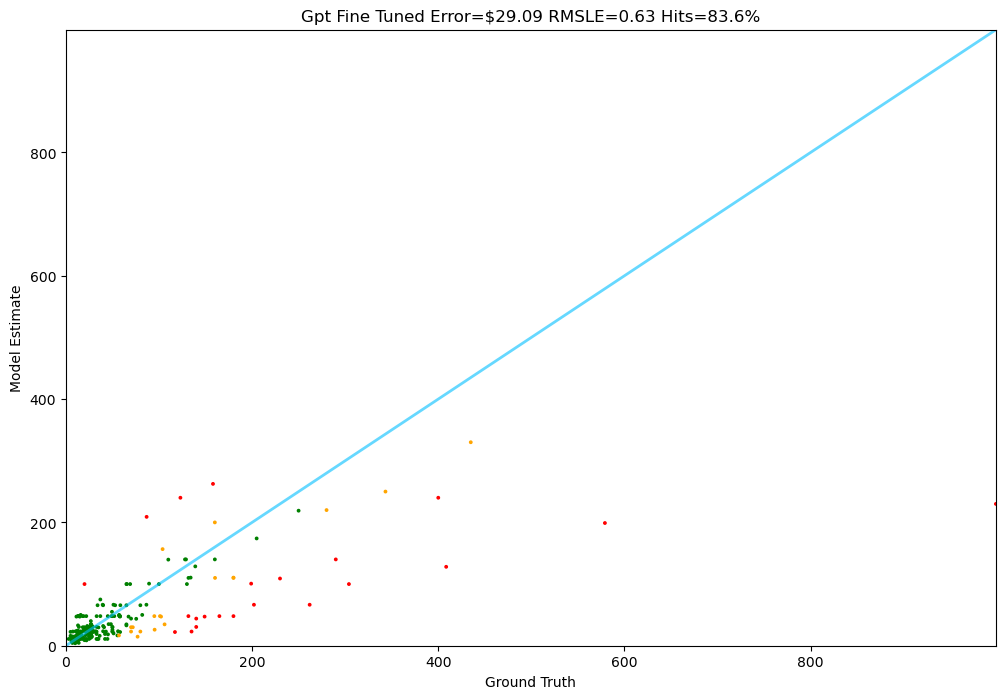

In [38]:
Tester.test(gpt_fine_tuned, test)